# Replication of Newman *et al.* (2015) *in-vitro* optoclamp

*with an alternate opsin pair*

*(last run with Cleo v0.15.0)*

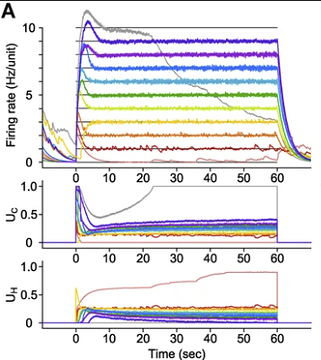

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import brian2.only as b2
import cleo

b2.prefs.codegen.target = "cython"
rng = np.random.default_rng()
plt.rc("svg", fonttype="none")

## Balanced E/I network
from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network)

In [185]:
from random import sample

b2.defaultclock.dt = 0.2 * b2.ms

N_Excit = 800
N_Inhib = None  # None = N_Excit / 4
N_extern = 1000
connection_probability = 0.1
w0 = 0.78 * b2.mV
g = 7.5
synaptic_delay = 1.5 * b2.ms
poisson_input_rate = 8.2 * b2.Hz
w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
monitored_subset_size = 100
random_vm_init = True
"""
Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

Args:
    N_Excit (int): Size of the excitatory popluation
    N_Inhib (int): optional. Size of the inhibitory population.
        If not set (=None), N_Inhib is set to N_excit/4.
    N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
        this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
        from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
        N_Excit*connection_probability.
    connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
        CE = connection_probability*N_Excit
        CI = connection_probability*N_Inhib
        Cexternal = N_extern
    w0 (float): Synaptic strength J
    g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
    synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
    poisson_input_rate (Quantity): Poisson rate of the external population
    w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
        neurons in the network. Default is None, in that case w_external is set to w0, which is the
        standard value in the book and in the paper Brunel2000.
        The purpose of this parameter is to see the effect of external input in the
        absence of network feedback(setting w0 to 0mV and w_external>0).
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset potential
    firing_threshold (Quantity): Spike threshold
    membrane_time_scale (Quantity): tau_m
    abs_refractory_period (Quantity): absolute refractory period, tau_ref
    monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
    random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
        random value drawn from Uniform(v_rest, firing_threshold)
    sim_time (Quantity): Simulation time

Returns:
    (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
    PopulationRateMonitor: Rate Monitor
    SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
    StateMonitor: membrane voltage for a selected subset of neurons
    list: index of monitored neurons. length = monitored_subset_size
"""
if N_Inhib is None:
    N_Inhib = int(N_Excit / 4)
if N_extern is None:
    N_extern = int(N_Excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
dv/dt = (-(v-v_rest) + Rm*(I_exc + I_inh)) / membrane_time_scale : volt (unless refractory)
I_exc : amp
I_inh : amp
"""

neurons = b2.NeuronGroup(
    N_Excit + N_Inhib,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_Excit + N_Inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_Excit]
inhibitory_population = neurons[N_Excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    on_pre="v += J_excit",
    delay=synaptic_delay,
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    on_pre="v += J_inhib",
    delay=synaptic_delay,
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

# collect data of a subset of neurons:
monitored_subset_size = min(monitored_subset_size, (N_Excit + N_Inhib))
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)
# rate_monitor = b2.PopulationRateMonitor(neurons)
# record= some_list is not supported? :-(
# spike_monitor = b2.SpikeMonitor(neurons, record=idx_monitored_neurons)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    # rate_monitor,
    # spike_monitor,
    # voltage_monitor,
)

# net.run(3 * b2.second)
# plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=0.5)
# plt.xlim(0, 10000)

In [186]:
sim = cleo.CLSimulator(net)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/utilities.py:92: RuntimeWarning: invalid value encountered in divide
  c = (xyz_end - xyz_start) / cyl_length  # unit vector in direction of cylinder
 [py.warnings]


(<Figure size 640x440 with 1 Axes>,
 <Axes3D: xlabel='x [mm]', ylabel='y [mm]', zlabel='z [mm]'>)

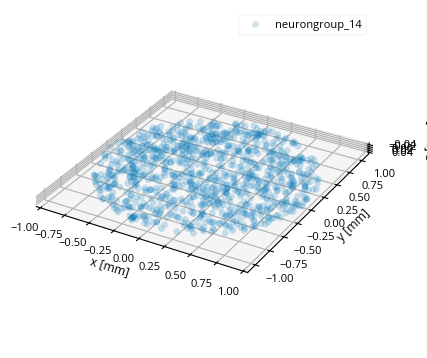

In [187]:
cleo.coords.assign_coords_rand_cylinder(neurons, [0, 0, 0], [0, 0, 0], 1)
cleo.viz.plot(neurons, xlim=[-1, 1], axis_scale_unit=b2.mm)

## Multi-electrode array (MEA)
Spacing appears to be 200 μm.

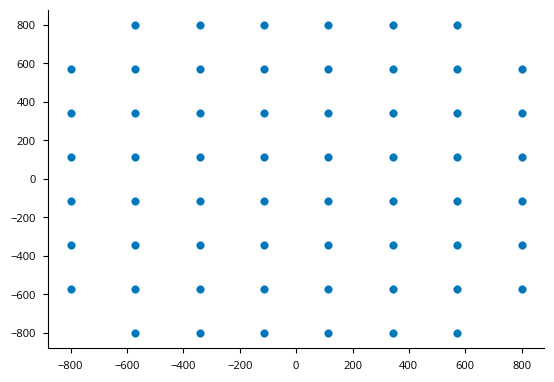

In [188]:
space = 200 * b2.um
n_side = 8
radius = space * n_side / 2
x, y = np.meshgrid(
    np.linspace(-radius, radius, n_side), np.linspace(-radius, radius, n_side)
)
y.shape
xy = np.column_stack([x.ravel(), y.ravel()]) * b2.meter
xy = np.delete(xy, [0, n_side - 1, -n_side, -1], 0) * b2.meter
plt.scatter(xy[:, 0] / b2.um, xy[:, 1] / b2.um)
# xy

(<Figure size 640x440 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

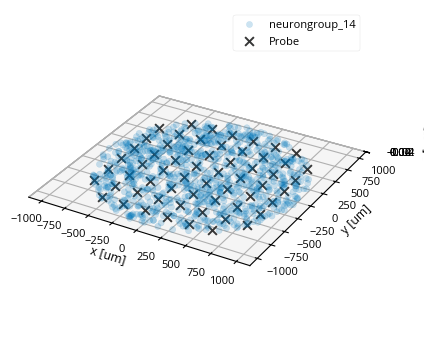

In [189]:
xyz = np.column_stack([xy, np.zeros(xy.shape[0])]) * b2.meter
spikes = cleo.ephys.SortedSpiking(
    r_perfect_detection=40 * b2.um, r_half_detection=80 * b2.um
)
probe = cleo.ephys.Probe(coords=xyz, signals=[spikes])
sim.inject(probe, neurons)
cleo.viz.plot(neurons, devices=[probe])

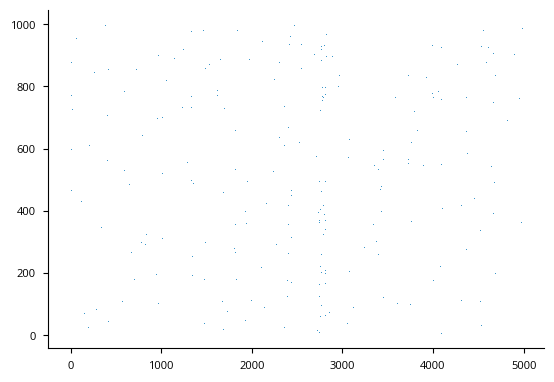

In [190]:
# sigma_ext = 0.05
# neurons.w_external_factor = rng.lognormal(0, sigma_ext, neurons.N) / np.exp(sigma_ext**2 / 2)
# plt.figure()
# plt.hist(neurons.w_external_factor)
# print(np.exp(sigma_ext**2 / 2))
# neurons.w_external_factor = 1
# w_external = 0.1 * b2.mV
# w0 = 0.78 * b2.mV
# w0 = 0 * b2.mV
# J_excit = w0
# J_inhib = -g * w0
sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
sim.run(5 * b2.second)
plt.figure()
plt.scatter(spikes.t_ms, spikes.i, s=0.2)
sim.reset()
# plt.xlim(0, 10000)

## Optogenetics

In [191]:
blue = cleo.light.Light(
    name="blue light",
    coords=[0, 0, -100] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=450 * b2.nmeter,
)
sim.inject(blue, neurons)
sigma_expr = 0.2
gtacr2 = cleo.opto.gtacr2_4s()
sim.inject(
    gtacr2,
    neurons,
    Iopto_var_name="I_inh",
    rho_rel=0.3 * rng.lognormal(0, sigma_expr, neurons.N) / np.exp(sigma_expr**2 / 2),
)

yellow = cleo.light.Light(
    name="yellow light",
    coords=[0, 0, -250] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=590 * b2.nmeter,
)
sim.inject(yellow, neurons)
vfc = cleo.opto.chrimson_4s()
vfc.extrapolate = True
sim.inject(
    vfc,
    neurons,
    Iopto_var_name="I_exc",
    rho_rel=0.3 * rng.lognormal(0, sigma_expr, neurons.N) / np.exp(sigma_expr**2 / 2),
)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/light/light_dependence.py:129: UserWarning: λ = 590.0 nm is outside the range of the action spectrum data for GtACR2 and extrapolate=False. Assuming ε = 0.
  warnings.warn(
 [py.warnings]
WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/light/light_dependence.py:135: UserWarning: λ = 450.0 nm is outside the range of the action spectrum data for Chrimson. Extrapolating: ε = 0.259.
  warnings.warn(
 [py.warnings]


CLSimulator(io_processor=RecordOnlyProcessor(sample_period_ms=1, sampling='fixed', processing='parallel'), devices={Light(name='blue light', save_history=True, value=array([0.]), light_model=Koehler(radius=1. * mmetre, zmax=0.5 * mmetre), wavelength=0.45 * umetre, direction=array([0., 0., 1.]), max_Irr0_mW_per_mm2=None, max_Irr0_mW_per_mm2_viz=None), BansalFourStateOpsin(name='Chrimson', save_history=True, on_pre='', spectrum=[(470.0, 0.38758499670980484), (490.0, 0.5636440143067537), (510.0, 0.795027289266222), (530.0, 0.8315502820462946), (550.0, 0.9402061855670104), (570.0, 1.0), (590.0, 0.9959811287786127), (610.0, 0.847726888625993), (630.0, 0.5130093274423172)], extrapolate=True, required_vars=[('Iopto', amp), ('v', volt)], Gd1=41. * hertz, Gd2=10. * hertz, Gr0=0.667 * mhertz, g0=22. * nsiemens, phim=2.e+20 * (second ** -1) / (meter ** 2), k1=50. * hertz, k2=0.5 * khertz, Gf0=1. * hertz, Gb0=10. * hertz, kf=10. * hertz, kb=4. * hertz, gamma=0.05, p=1, q=1, E=0. * volt, model='\n 

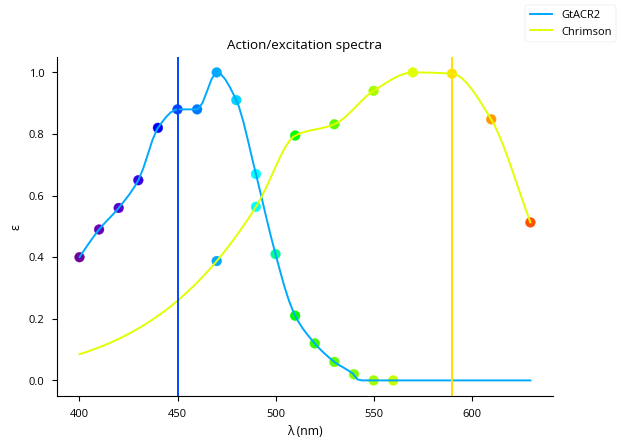

In [192]:
fig, ax = cleo.light.plot_spectra(gtacr2, vfc, extrapolate=True)
ax.axvline(blue.wavelength / b2.nmeter, color=blue.color)
ax.axvline(yellow.wavelength / b2.nmeter, color=yellow.color)

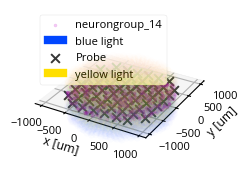

In [193]:
fig, ax = cleo.viz.plot(
    sim=sim, colors=["#c500cc"], figsize=(2.2, 2.2), scatterargs=dict(s=5)
)
ax.set(zticks=[])
# legend above plot
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig(
    "img/fig/optoclamp-3d-alt.svg", dpi=300, bbox_inches="tight", transparent=True
)

## Eyeball test
Trying different levels of stimulation to ensure network activity looks roughly like the following:

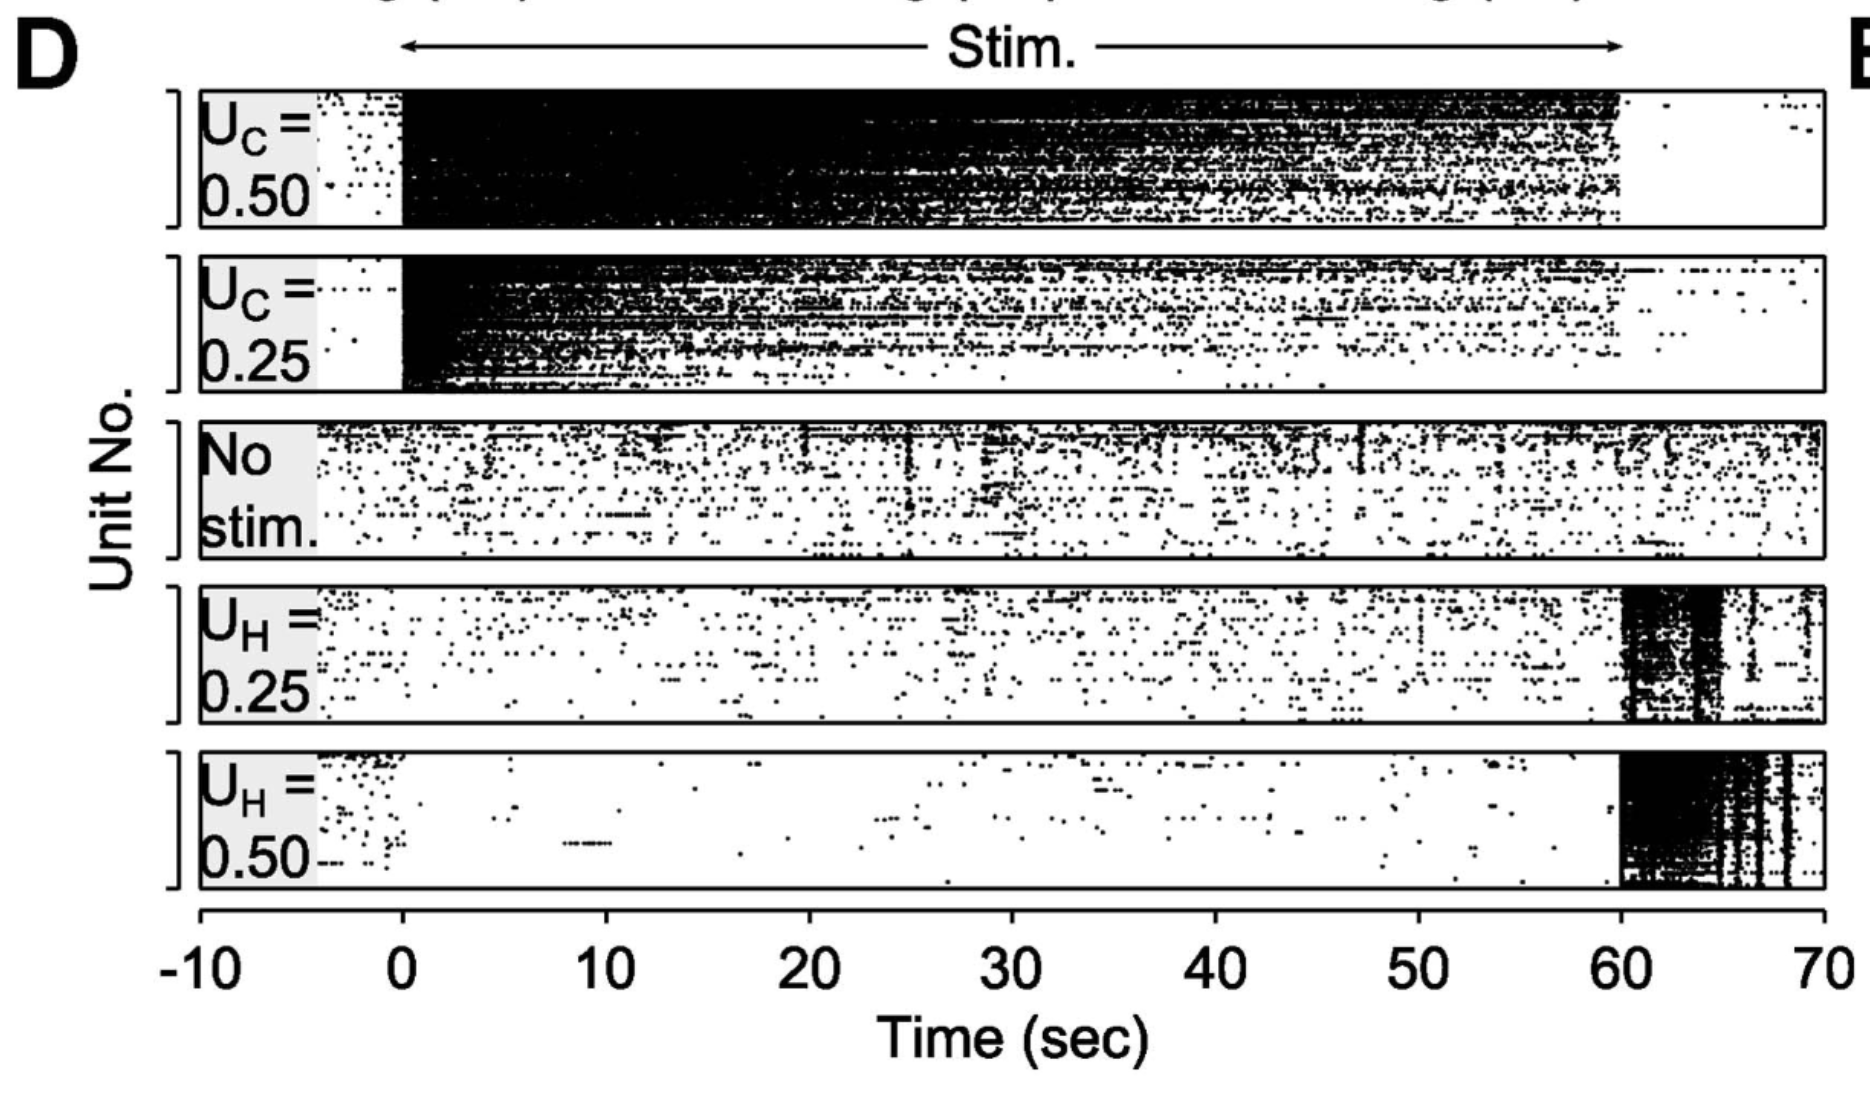

In [194]:
test_length_s = 9
intrvl_ms = test_length_s * 1000 / 9
amp_UH = 0.0005
amp_UC = 13.2


class TestIOProc(cleo.ioproc.LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period_ms=1)
        self.UC_hist = []
        self.UH_hist = []

    def process(self, state_dict, t_sample_ms):
        UC, UH = 0, 0
        if 1 * intrvl_ms <= t_sample_ms < 2 * intrvl_ms:
            UC = 0.5
        elif 3 * intrvl_ms <= t_sample_ms < 4 * intrvl_ms:
            UC = 0.25
        elif 5 * intrvl_ms <= t_sample_ms < 6 * intrvl_ms:
            UH = 0.25
        elif 7 * intrvl_ms <= t_sample_ms < 8 * intrvl_ms:
            UH = 0.5

        self.UC_hist.append(UC)
        self.UH_hist.append(UH)
        return {"blue light": UH, "yellow light": UC}, t_sample_ms

    def preprocess_ctrl_signals(self, latest_ctrl_signals, t_ms):
        out = {}
        t = t_ms * b2.ms
        UC = latest_ctrl_signals.get("yellow light", 0)
        pulse_freq_exc = (50 * UC + 10) * b2.Hz
        pulse_width_exc = 5 * UC * b2.ms
        power_exc = amp_UC * UC
        on_exc = t % (1 / pulse_freq_exc) < pulse_width_exc
        out["yellow light"] = on_exc * power_exc

        UH = latest_ctrl_signals.get("blue light", 0)
        out["blue light"] = UH * amp_UH
        return out


sim.reset()
test_proc = TestIOProc()
sim.set_io_processor(test_proc)
sim.run(test_length_s * b2.second, report="text")

INFO       No numerical integration method specified for group 'syn_Chrimson_neurongroup_14', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_GtACR2_neurongroup_14', using method 'euler' (took 0.50s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 9. s
0.7238 s (8%) simulated in 10s, estimated 1m 54s remaining.
1.4716 s (16%) simulated in 20s, estimated 1m 42s remaining.
2.176 s (24%) simulated in 30s, estimated 1m 34s remaining.
2.9276 s (32%) simulated in 40s, estimated 1m 23s remaining.
3.6822 s (40%) simulated in 50s, estimated 1m 12s remaining.
4.4102 s (49%) simulated in 1m 0s, estimated 1m 2s remaining.
5.1488 s (57%) simulated in 1m 10s, estimated 52s remaining.
5.8674 s (65%) simulated in 1m 20s, estimated 43s remaining.
6.5004 s (72%) simulated in 1m 30s, estimated 35s remaining.
6.947 s (77%) simulated in 1m 40s, estimated 30s remaining.
7.5074 s (83%) simulated in 1m 50s, estimated 22s remaining.
8.1664 s (90%) simulated in 2m 0s, estimated 12s remaining.
8.9268 s (99%) simulated in 2m 10s, estimated 1s remaining.
9. s (100%) simulated in 2m 11s


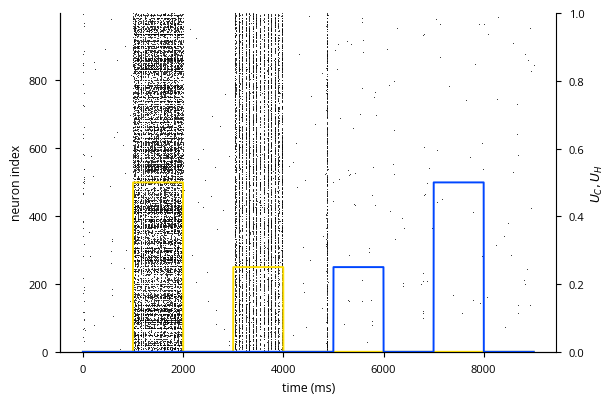

In [195]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.scatter(spikes.t_ms, spikes.i, s=0.2, color="k")
ax.set(ylim=[0, max(spikes.i)], ylabel="neuron index", xlabel="time (ms)")
ax.spines["right"].set_visible(True)
ax2.plot(test_proc.t_samp_ms, test_proc.UC_hist, color=yellow.color, label="$U_C$")
ax2.plot(test_proc.t_samp_ms, test_proc.UH_hist, color=blue.color, label="$U_H$")
ax2.set(ylim=[0, 1], ylabel="$U_C, U_H$");

## PI control
Exactly the same, but $U_C$ now controls the yellow light, and $U_H$ controls the blue light.
Yes, the naming is now confusing.

In [196]:
class Controller(cleo.ioproc.LatencyIOProcessor):
    def __init__(self, sample_period_ms=4):
        super().__init__(sample_period_ms=sample_period_ms)
        self.fre = cleo.ioproc.FiringRateEstimator(
            tau_ms=2500, sample_period_ms=sample_period_ms
        )
        self.Ts = 0.01 * b2.second  # control period (round-trip time)
        self.Ti = 1 * b2.second  # integral time constant
        self.K = 0.1  # proportional gain
        self.u = 0
        self.ef_prev = 0
        self.Δ = 0.25  # overlap between ChR2 and eNpHR3
        self.uu = []
        self.UCs = []
        self.UHs = []
        self.frs = []
        self.target = 1
        self.timepoints = [10, 20, 80, 90] * b2.second
        # self.timepoints = [1, 2, 3, 4] * b2.second * 5
        # self.timepoints = [2, 7, 22, 27] * b2.second

    def process(self, state_dict, t_sample_ms):
        t = t_sample_ms * b2.ms
        _, _, spike_counts = state_dict["Probe"]["SortedSpiking"]
        f, _ = self.fre.process(spike_counts, t_sample_ms, sample_time_ms=t_sample_ms)
        f = np.mean(f)
        self.frs.append(f)
        if t < self.timepoints[0]:
            UC = 1
            UH = 0
        elif t < self.timepoints[1]:
            UC = 0
            UH = 0
        elif t < self.timepoints[2]:
            ef = self.target - f  # error in firing rate
            self.u = self.u + self.K * (ef - self.ef_prev + self.Ts / self.Ti * ef)
            self.uu.append(self.u)
            UC = self.u + self.Δ
            UC = np.clip(UC, 0, 1)
            UH = -self.u + self.Δ
            UH = np.clip(UH, 0, 1)
            self.ef_prev = ef
        elif t >= self.timepoints[2]:
            UC = 0
            UH = 0

        self.UCs.append(UC)
        self.UHs.append(UH)

        return {"blue light": UH, "yellow light": UC}, t_sample_ms + self.Ts / b2.ms

    def preprocess_ctrl_signals(self, latest_ctrl_signals, t_ms):
        out = {}
        t = t_ms * b2.ms
        UC = latest_ctrl_signals.get("yellow light", 0)
        pulse_freq_exc = (10 * UC + 10) * b2.Hz
        pulse_width_exc = 5 * UC * b2.ms
        power_exc = amp_UC * UC
        on_exc = t % (1 / pulse_freq_exc) < pulse_width_exc
        out["yellow light"] = on_exc * power_exc

        UH = latest_ctrl_signals.get("blue light", 0)
        out["blue light"] = UH * amp_UH
        return out


ctrlr = Controller()

In [197]:
def plot_results(t_ms, frs, UCs, UHs, target):
    t = np.array(t_ms) / 1000
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3, 3))
    axs[0].plot(t, frs)
    axs[0].set(ylabel="firing rate (Hz)")
    axs[0].hlines(target, ctrlr.timepoints[1], ctrlr.timepoints[2])
    axs[1].plot(t, UCs, label="$U_C$", color=yellow.color)
    axs[1].plot(t, UHs, label="$U_H$", color=blue.color)
    axs[1].set(ylabel="$U_C,U_H$", xlabel="time (s)")
    axs[1].legend()
    display(fig)
    plt.close(fig)

In [198]:
results = {}

target = 0
Starting simulation at t=0. s for a duration of 90. s
1.8078 s (2%) simulated in 1m 0s, estimated 48m 47s remaining.
3.5836 s (3%) simulated in 2m 0s, estimated 48m 14s remaining.
5.2874 s (5%) simulated in 3m 0s, estimated 48m 4s remaining.
6.9138 s (7%) simulated in 4m 0s, estimated 48m 4s remaining.
8.6438 s (9%) simulated in 5m 0s, estimated 47m 4s remaining.
10.5148 s (11%) simulated in 6m 0s, estimated 45m 22s remaining.
12.1476 s (13%) simulated in 7m 0s, estimated 44m 52s remaining.
14.0104 s (15%) simulated in 8m 0s, estimated 43m 24s remaining.
15.9562 s (17%) simulated in 9m 0s, estimated 41m 46s remaining.
17.9348 s (19%) simulated in 10m 0s, estimated 40m 11s remaining.
19.8832 s (22%) simulated in 11m 0s, estimated 38m 48s remaining.
21.6122 s (24%) simulated in 12m 0s, estimated 37m 58s remaining.
23.491 s (26%) simulated in 13m 0s, estimated 36m 49s remaining.
25.1564 s (27%) simulated in 14m 0s, estimated 36m 5s remaining.
26.8396 s (29%) simulated in 15m 0s

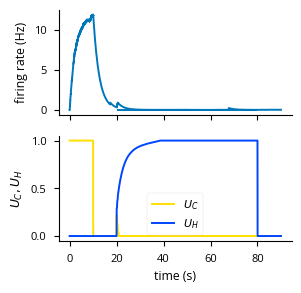

target = 1
Starting simulation at t=0. s for a duration of 90. s
1.6894 s (1%) simulated in 1m 0s, estimated 52m 17s remaining.
3.4012 s (3%) simulated in 2m 0s, estimated 50m 56s remaining.
5.2154 s (5%) simulated in 3m 0s, estimated 48m 46s remaining.
6.911 s (7%) simulated in 4m 0s, estimated 48m 6s remaining.
8.7484 s (9%) simulated in 5m 0s, estimated 46m 26s remaining.
10.563 s (11%) simulated in 6m 0s, estimated 45m 7s remaining.
12.3034 s (13%) simulated in 7m 0s, estimated 44m 12s remaining.
14.128 s (15%) simulated in 8m 0s, estimated 42m 58s remaining.
16.0088 s (17%) simulated in 9m 0s, estimated 41m 36s remaining.
18.0068 s (20%) simulated in 10m 0s, estimated 39m 59s remaining.
19.8118 s (22%) simulated in 11m 0s, estimated 38m 58s remaining.
21.5134 s (23%) simulated in 29m 54s, estimated 1h 35m 11s remaining.
24.2122 s (26%) simulated in 30m 54s, estimated 1h 23m 58s remaining.
27.9306 s (31%) simulated in 31m 54s, estimated 1h 10m 53s remaining.
32.0224 s (35%) simulat

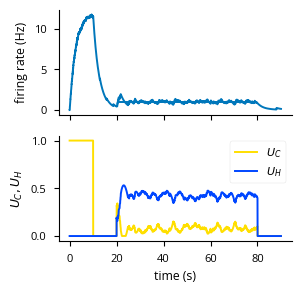

target = 2
Starting simulation at t=0. s for a duration of 90. s
2.5798 s (2%) simulated in 1m 0s, estimated 33m 53s remaining.
5.184 s (5%) simulated in 2m 0s, estimated 32m 43s remaining.
7.5926 s (8%) simulated in 3m 0s, estimated 32m 34s remaining.
10.2606 s (11%) simulated in 4m 0s, estimated 31m 5s remaining.
13.138 s (14%) simulated in 5m 0s, estimated 29m 15s remaining.
16.17 s (17%) simulated in 6m 0s, estimated 27m 24s remaining.
19.3044 s (21%) simulated in 7m 0s, estimated 25m 38s remaining.
22.351 s (24%) simulated in 8m 0s, estimated 24m 13s remaining.
23.5512 s (26%) simulated in 9m 0s, estimated 25m 24s remaining.
26.1404 s (29%) simulated in 10m 0s, estimated 24m 26s remaining.
30.0198 s (33%) simulated in 11m 0s, estimated 21m 59s remaining.
32.0216 s (35%) simulated in 12m 0s, estimated 21m 44s remaining.
33.6184 s (37%) simulated in 13m 0s, estimated 21m 48s remaining.
35.2714 s (39%) simulated in 14m 0s, estimated 21m 43s remaining.
37.1564 s (41%) simulated in 15m

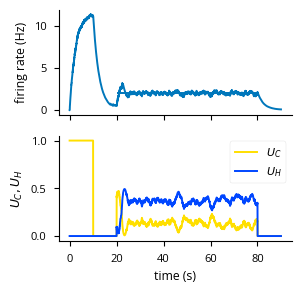

target = 3
Starting simulation at t=0. s for a duration of 90. s
1.5158 s (1%) simulated in 1m 0s, estimated 58m 23s remaining.
3.5292 s (3%) simulated in 2m 0s, estimated 49m 0s remaining.
5.6376 s (6%) simulated in 3m 0s, estimated 44m 54s remaining.
7.8452 s (8%) simulated in 4m 0s, estimated 41m 53s remaining.
10.2638 s (11%) simulated in 5m 0s, estimated 38m 51s remaining.
12.538 s (13%) simulated in 6m 0s, estimated 37m 4s remaining.
15.0366 s (16%) simulated in 7m 0s, estimated 34m 54s remaining.
17.403 s (19%) simulated in 8m 0s, estimated 33m 22s remaining.
19.7744 s (21%) simulated in 9m 0s, estimated 31m 58s remaining.
22.2686 s (24%) simulated in 10m 0s, estimated 30m 25s remaining.
24.7322 s (27%) simulated in 11m 0s, estimated 29m 2s remaining.
27.0488 s (30%) simulated in 12m 0s, estimated 27m 56s remaining.
29.5846 s (32%) simulated in 13m 0s, estimated 26m 33s remaining.
31.8554 s (35%) simulated in 14m 0s, estimated 25m 33s remaining.
34.1758 s (37%) simulated in 15m 

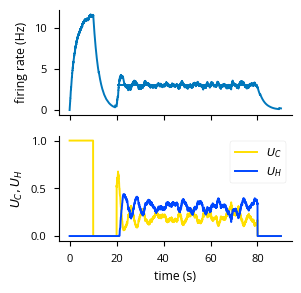

target = 4
Starting simulation at t=0. s for a duration of 90. s
3.2816 s (3%) simulated in 1m 0s, estimated 26m 26s remaining.
6.4618 s (7%) simulated in 2m 0s, estimated 25m 51s remaining.
8.6896 s (9%) simulated in 3m 0s, estimated 28m 4s remaining.
12.5758 s (13%) simulated in 4m 0s, estimated 24m 38s remaining.
15.474 s (17%) simulated in 5m 0s, estimated 24m 5s remaining.
18.2862 s (20%) simulated in 6m 0s, estimated 23m 32s remaining.
22.3926 s (24%) simulated in 7m 0s, estimated 21m 8s remaining.
25.883 s (28%) simulated in 8m 0s, estimated 19m 49s remaining.
28.7422 s (31%) simulated in 9m 0s, estimated 19m 11s remaining.
31.1832 s (34%) simulated in 10m 0s, estimated 18m 52s remaining.
33.7216 s (37%) simulated in 11m 0s, estimated 18m 22s remaining.
36.12 s (40%) simulated in 12m 0s, estimated 17m 54s remaining.
38.5136 s (42%) simulated in 13m 0s, estimated 17m 23s remaining.
40.9518 s (45%) simulated in 14m 0s, estimated 16m 46s remaining.
44.8824 s (49%) simulated in 15m 

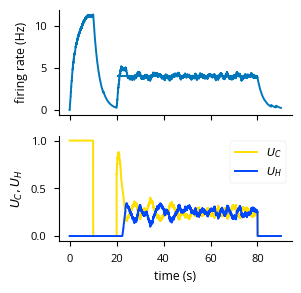

target = 5
Starting simulation at t=0. s for a duration of 90. s
2.6406 s (2%) simulated in 1m 0s, estimated 33m 5s remaining.
6.0414 s (6%) simulated in 2m 0s, estimated 27m 48s remaining.
9.1228 s (10%) simulated in 3m 0s, estimated 26m 36s remaining.
12.8012 s (14%) simulated in 4m 0s, estimated 24m 7s remaining.
16.5836 s (18%) simulated in 5m 0s, estimated 22m 8s remaining.
20.2402 s (22%) simulated in 6m 0s, estimated 20m 41s remaining.
23.624 s (26%) simulated in 7m 0s, estimated 19m 40s remaining.
27.2858 s (30%) simulated in 8m 0s, estimated 18m 23s remaining.
30.9922 s (34%) simulated in 9m 0s, estimated 17m 8s remaining.
34.6308 s (38%) simulated in 10m 0s, estimated 15m 59s remaining.
38.3274 s (42%) simulated in 11m 0s, estimated 14m 50s remaining.
42.2644 s (46%) simulated in 12m 0s, estimated 13m 33s remaining.
45.9108 s (51%) simulated in 13m 0s, estimated 12m 29s remaining.
49.7188 s (55%) simulated in 14m 0s, estimated 11m 21s remaining.
53.5556 s (59%) simulated in 1

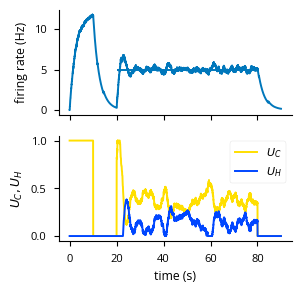

target = 6
Starting simulation at t=0. s for a duration of 90. s
2.5158 s (2%) simulated in 1m 0s, estimated 34m 46s remaining.
6.1818 s (6%) simulated in 2m 0s, estimated 27m 7s remaining.
9.8676 s (10%) simulated in 3m 0s, estimated 24m 22s remaining.
13.5038 s (15%) simulated in 4m 0s, estimated 22m 40s remaining.
17.1886 s (19%) simulated in 5m 0s, estimated 21m 11s remaining.
20.7424 s (23%) simulated in 6m 0s, estimated 20m 2s remaining.
24.319 s (27%) simulated in 7m 0s, estimated 18m 54s remaining.
27.708 s (30%) simulated in 8m 0s, estimated 17m 59s remaining.
31.198 s (34%) simulated in 9m 0s, estimated 16m 58s remaining.
34.6792 s (38%) simulated in 10m 0s, estimated 15m 57s remaining.
37.9636 s (42%) simulated in 11m 0s, estimated 15m 5s remaining.
41.2722 s (45%) simulated in 12m 0s, estimated 14m 10s remaining.
44.84 s (49%) simulated in 13m 0s, estimated 13m 6s remaining.
48.222 s (53%) simulated in 14m 0s, estimated 12m 8s remaining.
51.7898 s (57%) simulated in 15m 0s,

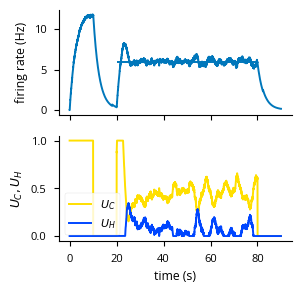

target = 7
Starting simulation at t=0. s for a duration of 90. s
1.6274 s (1%) simulated in 1m 0s, estimated 54m 19s remaining.
3.3784 s (3%) simulated in 2m 0s, estimated 51m 17s remaining.
5.0874 s (5%) simulated in 3m 0s, estimated 50m 5s remaining.
6.8344 s (7%) simulated in 4m 0s, estimated 48m 41s remaining.
8.5248 s (9%) simulated in 5m 0s, estimated 47m 47s remaining.
10.4666 s (11%) simulated in 6m 0s, estimated 45m 36s remaining.
12.1218 s (13%) simulated in 7m 0s, estimated 44m 58s remaining.
13.8344 s (15%) simulated in 8m 0s, estimated 44m 3s remaining.
15.3852 s (17%) simulated in 9m 0s, estimated 43m 39s remaining.
16.7086 s (18%) simulated in 10m 0s, estimated 43m 52s remaining.
18.3518 s (20%) simulated in 11m 0s, estimated 42m 57s remaining.
19.7902 s (21%) simulated in 12m 0s, estimated 42m 35s remaining.
21.2502 s (23%) simulated in 13m 0s, estimated 42m 4s remaining.
22.9244 s (25%) simulated in 14m 0s, estimated 40m 58s remaining.
24.5758 s (27%) simulated in 15m 

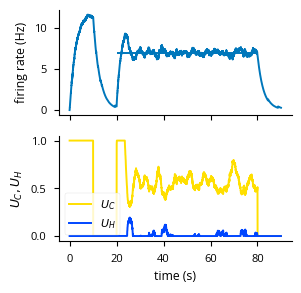

results for target 8 already saved. skipping.
target = 9
Starting simulation at t=0. s for a duration of 90. s
3.291 s (3%) simulated in 1m 0s, estimated 26m 21s remaining.
7.5514 s (8%) simulated in 2m 0s, estimated 21m 50s remaining.
11.6208 s (12%) simulated in 3m 0s, estimated 20m 14s remaining.
15.98 s (17%) simulated in 4m 0s, estimated 18m 32s remaining.
20.2664 s (22%) simulated in 5m 0s, estimated 17m 12s remaining.
24.1254 s (26%) simulated in 6m 0s, estimated 16m 23s remaining.
28.37 s (31%) simulated in 7m 0s, estimated 15m 12s remaining.
32.2798 s (35%) simulated in 8m 0s, estimated 14m 18s remaining.
36.3486 s (40%) simulated in 9m 0s, estimated 13m 17s remaining.
40.4694 s (44%) simulated in 10m 0s, estimated 12m 14s remaining.
44.4428 s (49%) simulated in 11m 0s, estimated 11m 17s remaining.
48.5808 s (53%) simulated in 12m 0s, estimated 10m 14s remaining.
51.9368 s (57%) simulated in 13m 0s, estimated 9m 32s remaining.
55.7928 s (61%) simulated in 14m 0s, estimated 8m 

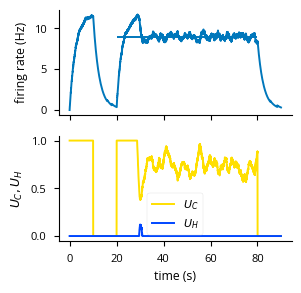

target = 10
Starting simulation at t=0. s for a duration of 90. s
2.7952 s (3%) simulated in 1m 0s, estimated 31m 12s remaining.
6.7682 s (7%) simulated in 2m 0s, estimated 24m 36s remaining.
10.7906 s (11%) simulated in 3m 0s, estimated 22m 1s remaining.
14.7746 s (16%) simulated in 4m 0s, estimated 20m 22s remaining.
18.9268 s (21%) simulated in 5m 0s, estimated 18m 47s remaining.
22.8222 s (25%) simulated in 6m 0s, estimated 17m 40s remaining.
26.8324 s (29%) simulated in 7m 0s, estimated 16m 29s remaining.
30.7792 s (34%) simulated in 8m 0s, estimated 15m 24s remaining.
34.7584 s (38%) simulated in 9m 0s, estimated 14m 18s remaining.
38.6186 s (42%) simulated in 10m 0s, estimated 13m 18s remaining.
42.5778 s (47%) simulated in 11m 0s, estimated 12m 15s remaining.
46.287 s (51%) simulated in 12m 0s, estimated 11m 20s remaining.
49.915 s (55%) simulated in 13m 0s, estimated 10m 26s remaining.
53.9228 s (59%) simulated in 14m 0s, estimated 9m 22s remaining.
57.7076 s (64%) simulated i

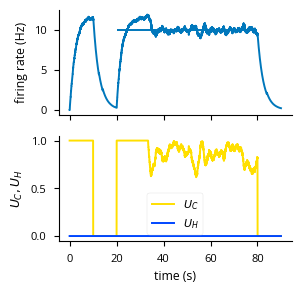

In [204]:
from IPython.display import display
import pickle
import os


def fname(target):
    return f"results/results_alt_{target}.pkl"


targets = range(11)
# targets = [2, 3, 4, 5]
ctrlr = Controller()
for target in targets:
    filename = fname(target)
    if os.path.exists(filename):
        print(f"results for target {target} already saved. skipping.")
        continue

    ctrlr = Controller()
    sim.reset()
    sim.set_io_processor(ctrlr)
    ctrlr.target = target
    print(f"target = {target}")
    sim.run(ctrlr.timepoints[-1], report_period=60 * b2.second, report="text")

    results[target] = (
        ctrlr.t_samp_ms,
        ctrlr.frs,
        ctrlr.UCs,
        ctrlr.UHs,
    )
    with open(filename, "wb") as file:
        pickle.dump(results[target], file)

    plot_results(*results[target], target)

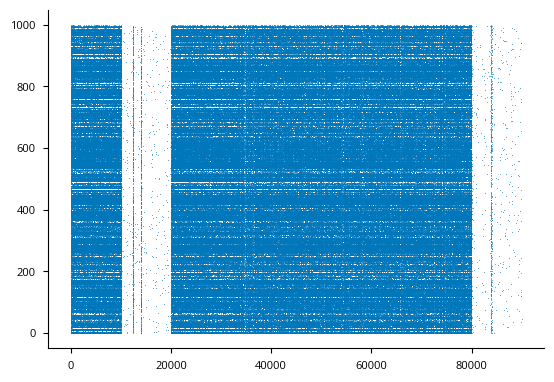

In [205]:
plt.scatter(spikes.t_ms, spikes.i, marker=".", s=0.5)

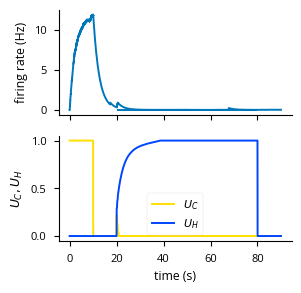

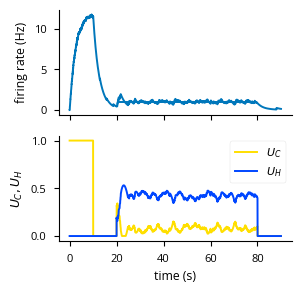

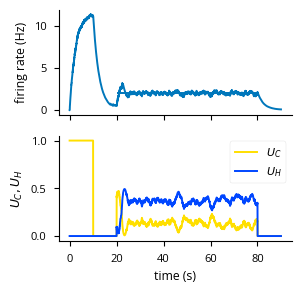

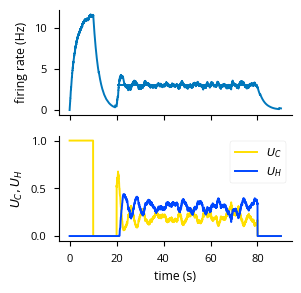

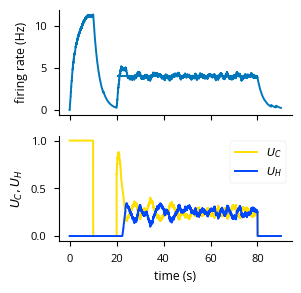

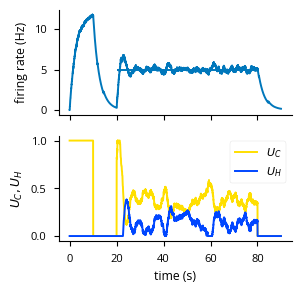

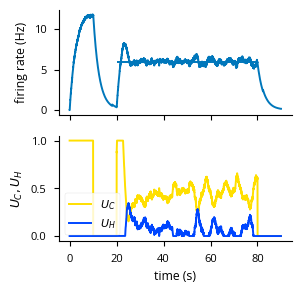

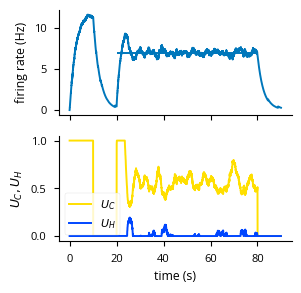

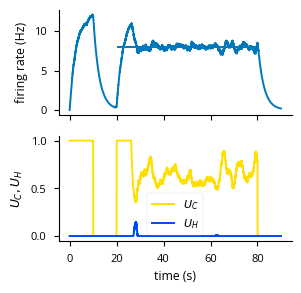

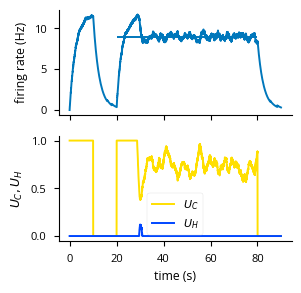

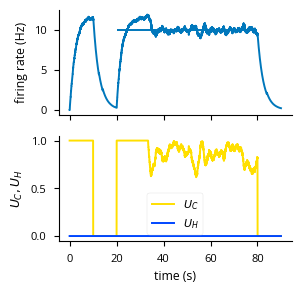

In [206]:
for target in targets:
    with open(fname(target), "rb") as file:
        t_ms, frs, UCs, UHs = pickle.load(file)
    plot_results(t_ms, frs, UCs, UHs, target)

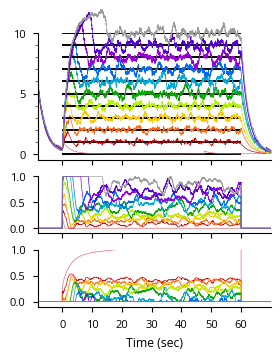

In [207]:
from matplotlib import ticker

plt.style.use("seaborn-v0_8-paper")
figwidth = 3
fig, axs = plt.subplots(
    3,
    1,
    sharex=True,
    figsize=(figwidth, figwidth * 3.2 / 2.7),
    height_ratios=[2.22, 1, 1],
    # layout="constrained",
)
rainbow_cycler = plt.cycler(
    color=[
        "#e56f72",
        "#cd0608",
        "#fd6b16",
        "#fdc803",
        "#b8f003",
        "#08a605",
        "#02a9d7",
        "#0169f1",
        "#9900d7",
        "#5601d5",
        "#9b9b9b",
    ]
)
for ax in axs:
    ax.set_prop_cycle(rainbow_cycler)

offset_s = 20
t_start_s = -8
lw = 0.5
for target in targets:
    with open(fname(target), "rb") as file:
        t_ms, frs, UCs, UHs = pickle.load(file)
    t = np.array(t_ms) / 1000 - offset_s
    axs[0].hlines(
        target,
        ctrlr.timepoints[1] / b2.second - offset_s,
        ctrlr.timepoints[2] / b2.second - offset_s,
        color="k",
    )
    axs[0].plot(t[t >= t_start_s], np.array(frs)[t >= t_start_s], clip_on=False, lw=lw)
    axs[0].set(
        # ylabel="Firing rate (Hz/unit)",
        ylim=[-0.5, 10],
        # yticks=range(0, 11, 1),
        # yticklabels=range(0, 11, 5),
    )
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
    axs[0].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    axs[1].plot(t, UCs, lw=lw)
    axs[1].set(
        # ylabel="$U_C$",
        ylim=[-0.1, 1],
        yticks=[0, 0.5, 1],
    )
    axs[2].plot(t, UHs, lw=lw)
    axs[2].set(
        # ylabel="$U_H$",
        xlabel="Time (sec)",
        ylim=[-0.1, 1],
        xlim=[t_start_s, max(t)],
        yticks=[0, 0.5, 1],
        xticks=range(0, 70, 10),
    )
    fig.savefig(
        "img/fig/optoclamp-frs-alt.png", dpi=300, bbox_inches="tight", transparent=True
    )

## Generate final combined figure

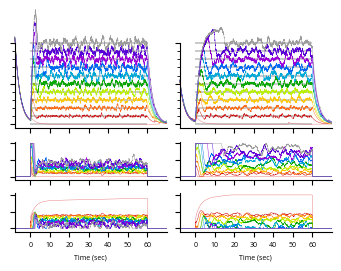

In [231]:
import matplotlib as mpl
from matplotlib import ticker


mpl.rc_file_defaults()
with plt.rc_context({"font.size": 5, "svg.fonttype": "none"}):
    fig, axs = plt.subplots(
        3,
        2,
        sharex=True,
        sharey="row",
        height_ratios=[2.22, 1, 1],
        figsize=(3.3, 2.6),
        layout="compressed",
    )
    rainbow_cycler = plt.cycler(
        color=[
            "#e56f72",
            "#cd0608",
            "#fd6b16",
            "#fdc803",
            "#b8f003",
            "#08a605",
            "#02a9d7",
            "#0169f1",
            "#9900d7",
            "#5601d5",
            "#9b9b9b",
        ]
    )
    for ax in axs.flatten():
        ax.set_prop_cycle(rainbow_cycler)

    offset_s = 20
    t_start_s = -8
    lw = 0.3

    for i_col, expt in enumerate(["", "_alt"]):
        for target in targets:
            with open(f"results/results{expt}_{target}.pkl", "rb") as file:
                t_ms, frs, UCs, UHs = pickle.load(file)
            t = np.array(t_ms) / 1000 - offset_s
            axs[0, i_col].hlines(
                target,
                ctrlr.timepoints[1] / b2.second - offset_s,
                ctrlr.timepoints[2] / b2.second - offset_s,
                color="k",
                lw=lw,
                clip_on=False,
            )
            axs[0, i_col].plot(
                t[t >= t_start_s],
                np.array(frs)[t >= t_start_s],
                clip_on=False,
                lw=lw,
                rasterized=True,
            )
            axs[0, i_col].set(
                # ylabel="Firing rate (Hz/unit)",
                ylim=[-0.5, 10],
                # yticks=range(0, 11, 1),
                # yticklabels=range(0, 11, 5),
                yticklabels=[],
            )
            axs[0, i_col].yaxis.set_major_locator(ticker.MultipleLocator(5))
            axs[0, i_col].yaxis.set_minor_locator(ticker.MultipleLocator(1))
            axs[1, i_col].plot(t, UCs, lw=lw, rasterized=True)
            axs[1, i_col].set(
                # ylabel="$U_C$",
                ylim=[-0.1, 1.05],
                yticks=[0, 0.5, 1],
                yticklabels=[],
            )
            axs[2, i_col].plot(t, UHs, lw=lw, rasterized=True)
            axs[2, i_col].set(
                # ylabel="$U_H$",
                xlabel="Time (sec)",
                ylim=[-0.1, 1.05],
                xlim=[t_start_s, max(t)],
                yticks=[0, 0.5, 1],
                yticklabels=[],
                xticks=range(0, 70, 10),
            )

    fig.savefig(
        "img/fig/optoclamp-combined.svg",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )